## **Vehicle Detection Project**

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.


- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.


- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

# Import Packages

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

C:\Users\danny\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read  all car and not car images

In [2]:
""" Sub function
"""
def getFileList(path):
    """ Function: Get ".png" file list
        arg     : file path
        return  : file pass list including file name """
    file_list = []
    for (root, dirs, files) in os.walk(path):
        for file in files:
            if '.png' in file:
                file_list.append( os.path.join(root,file).replace("\\", "/") )
        
    return file_list

""" Read all car and not cat images list
"""
cars = getFileList(r"../CarND-Vehicle-Detection-Dataset/vehicles")
print("Sample data name  : ", cars[0])
print("Number of car data: ", len(cars))

notcars = getFileList(r"../CarND-Vehicle-Detection-Dataset/non-vehicles")
print("Sample data name      : ", notcars[0])
print("Number of not car data: ", len(notcars))

Sample data name  :  ../CarND-Vehicle-Detection-Dataset/vehicles/GTI_Far/image0000.png
Number of car data:  8792
Sample data name      :  ../CarND-Vehicle-Detection-Dataset/non-vehicles/Extras/extra1.png
Number of not car data:  8968


### Plot a Sample image

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
Car image file name:  ../CarND-Vehicle-Detection-Dataset/vehicles/GTI_Left/image0441.png
Not Car image file name:  ../CarND-Vehicle-Detection-Dataset/non-vehicles/Extras/extra3420.png


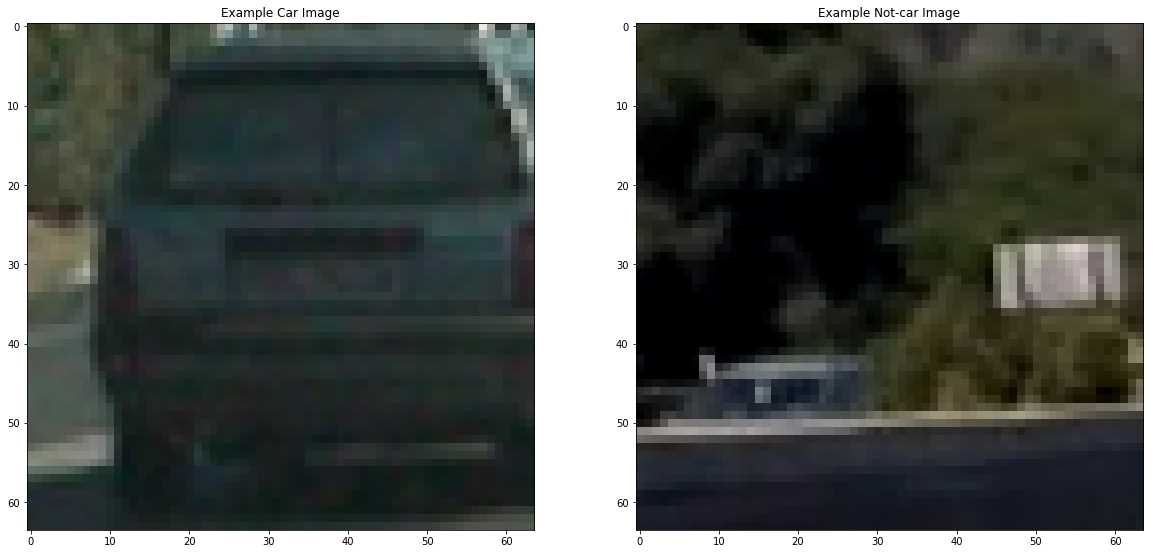

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    image = mpimg.imread(car_list[0]) # Read with RGB color channel
    data_dict["image_shape"] = image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
print("Car image file name: ", cars[car_ind])
print("Not Car image file name: ", notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(20,10))

plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Save
plt.savefig(r"./output_images/example_image.png")

## Helper functions

In [4]:
"""
 Helper Function
"""
def convert_color(img, conv='RGB2YCrCb'):
    """ Function: Convert a image of color space
        return: An image converted """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    
    # return the image copy with boxes drawn
    return draw_img

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """ Function: Creaete Histgram with RGB color channel
        return  : Feature Vector as histgram with RGB color """
    # Compute the histogram of the color channels like RGB separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    """ Function: Convert Image to Feature Vector after resize
        return: feature vector """ 
    # Convert image to new color space (if specified)
    img_resized = cv2.resize(img, size)
    # Create the feature vector
    features = img_resized.ravel() # # cv2.resize().ravel()
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """ Function: Calculate HOG features vector
        return: HOG feature vector and an image as HOG feature """ 
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                          cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                          cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features
    
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """ Function: Draw boxes
        return: An image with boxes """ 
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Anaysis for Color Space for detecting car using 3D Plot

In [47]:
""" These are sub function for visualizing the 3D Plot
"""
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """ Function: Plot pixels in 3D
        return  : 3D Plot """

    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=7, pad=5)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def plot3D_color_spaces(img_small):
    # Color for plot# Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV) # HSV
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV) # LUV
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS) # HLS
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV) # YUV
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb) # YCrCb
    # Color for plot
    img_small_rgb = img_small_RGB / 255.  # scalimg_small_YUVed to [0, 1], only for plotting
    
    return img_small_RGB,img_small_HSV,img_small_LUV,img_small_HLS,\
            img_small_YUV,img_small_YCrCb,img_small_rgb

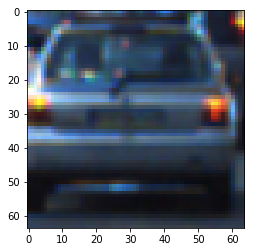

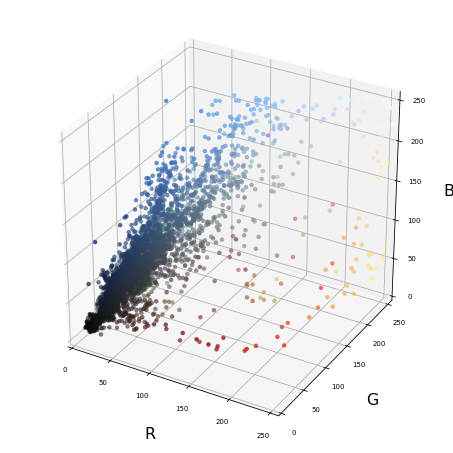

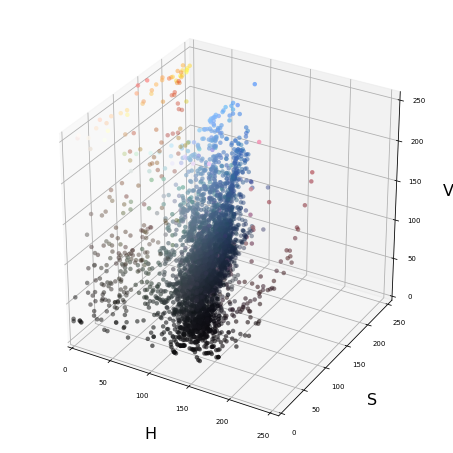

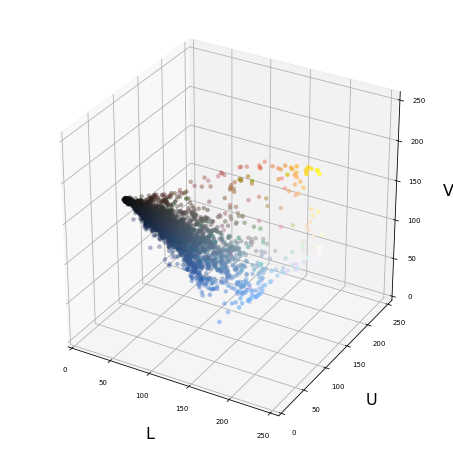

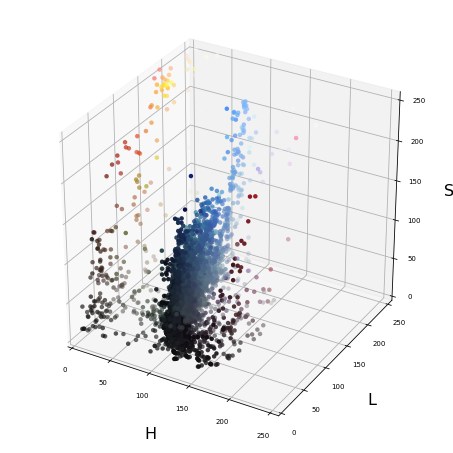

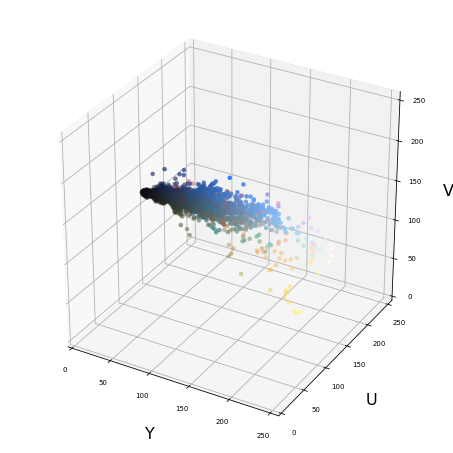

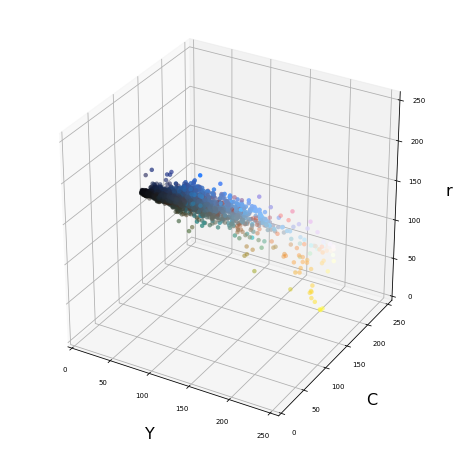

In [50]:
""" Visualizing the 3D Plot
"""
# Show base image
plt.imshow(car_image) # Note:RGB image
# Read a color image
img = cv2.imread(cars[car_ind]) # Note:BGR image

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
#print("scale is ", scale)
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB,img_small_HSV,img_small_LUV,img_small_HLS,\
 img_small_YUV,img_small_YCrCb,img_small_rgb = plot3D_color_spaces(img_small)


# Plot the examples
#fig, (ax_RGB, ax_HSV, ax_LUV, ax_HLS, ax_YUV, ax_YCrCb) = plt.subplots(1,6)
ax_RGB = plot3d(img_small_RGB, img_small_rgb)
ax_HSV = plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
ax_LUV = plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
ax_HLS = plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
ax_YUV = plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
ax_YCrCb = plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))

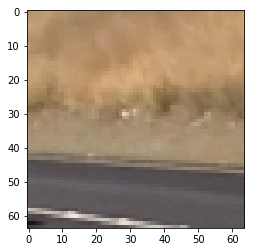

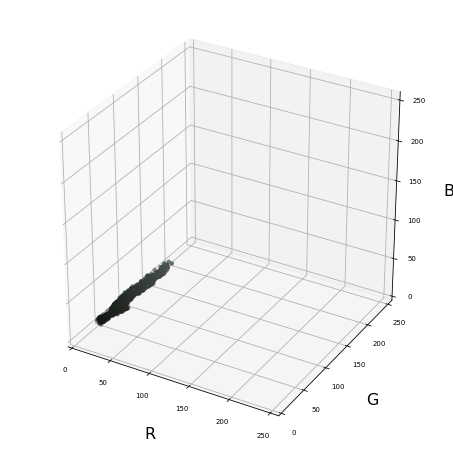

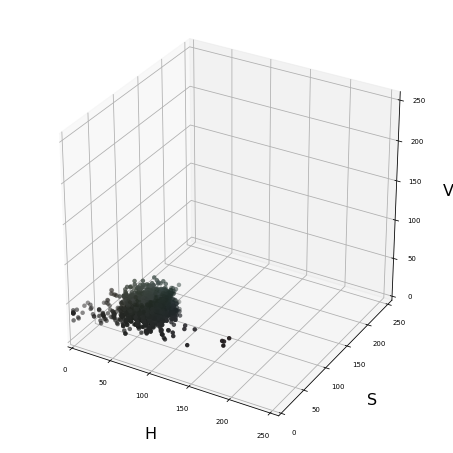

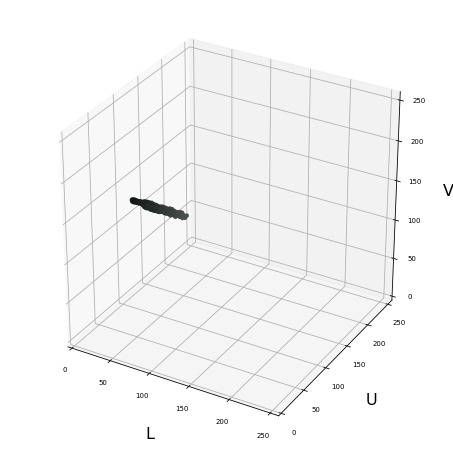

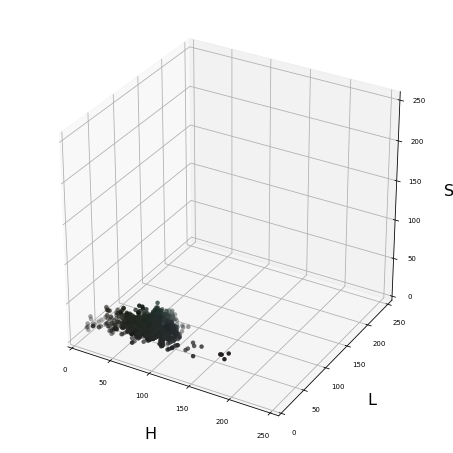

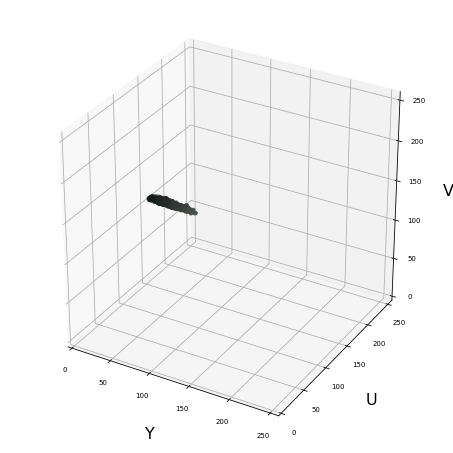

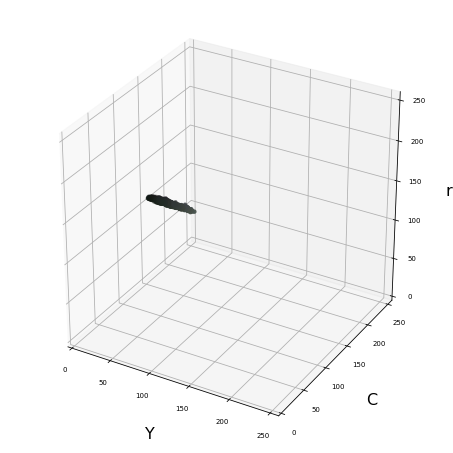

In [53]:
""" Visualizing the 3D Plot
"""
# Show base image
plt.imshow(notcar_image) # Note:RGB image
# Read a color image
img = cv2.imread(notcars[car_ind]) # Note:BGR image

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB,img_small_HSV,img_small_LUV,img_small_HLS,\
 img_small_YUV,img_small_YCrCb,img_small_rgb = plot3D_color_spaces(img_small)


# Plot the examples
#fig, (ax_RGB, ax_HSV, ax_LUV, ax_HLS, ax_YUV, ax_YCrCb) = plt.subplots(1,6)
ax_RGB = plot3d(img_small_RGB, img_small_rgb)
ax_HSV = plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
ax_LUV = plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
ax_HLS = plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
ax_YUV = plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
ax_YCrCb = plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))


### Analysis HOG parameters

In [71]:
""" Feature Extraction only HOG
"""
# Define a function to extract HOG features from a list of images
def extract_features_with_HOG(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """ Functoin: Extract HOG feature
        Return  : HOG features, color space feature image, HOG image"""
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel],\
                                              orient, pix_per_cell, \
                                              cell_per_block, vis=True, \
                                              feature_vec=True)
    # Return list of feature vectors
    return hog_features, feature_image, hog_image

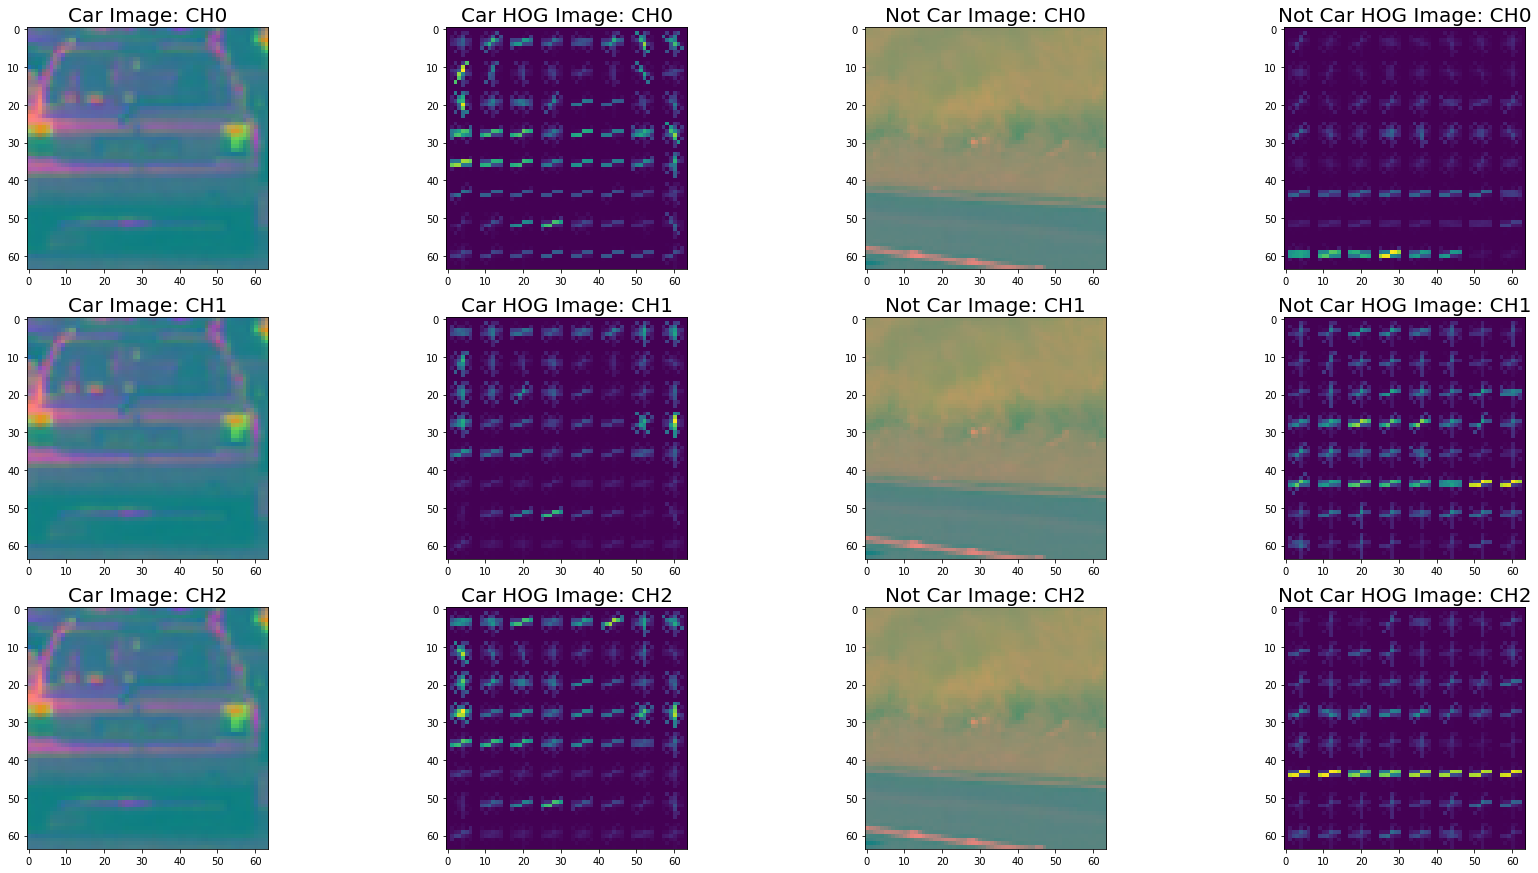

In [74]:
""" Analysis of HOG parameters
"""
# Define HOG parameters
cspace="YCrCb"
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Read a car image
car_img = cv2.imread(cars[car_ind]) # Note:BGR image
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
# Read a not car image
notcar_img = cv2.imread(notcars[notcar_ind]) # Note:BGR image
notcar_img = cv2.cvtColor(notcar_img, cv2.COLOR_BGR2RGB)

""" IN CASE OF : HOG CHANNEL 0
"""
hog_channel = 0
# car_image
car_features0, car_feature_image0, car_hog_image0 = extract_features_with_HOG(car_img, \
                        cspace=cspace,orient=orient, pix_per_cell=pix_per_cell,\
                        cell_per_block=cell_per_block, \
                        hog_channel=hog_channel)
# notcar_image
notcar_features0, notcar_feature_image0, notcar_hog_image0 = extract_features_with_HOG(notcar_img, \
                        cspace=cspace,orient=orient, pix_per_cell=pix_per_cell,\
                        cell_per_block=cell_per_block, \
                        hog_channel=hog_channel)

""" IN CASE OF : HOG CHANNEL 1
"""
hog_channel = 1
# car_image
car_features1, car_feature_image1, car_hog_image1 = extract_features_with_HOG(car_img, \
                        cspace=cspace,orient=orient, pix_per_cell=pix_per_cell,\
                        cell_per_block=cell_per_block, \
                        hog_channel=hog_channel)
# notcar_image
notcar_features1, notcar_feature_image1, notcar_hog_image1 = extract_features_with_HOG(notcar_img, \
                        cspace=cspace,orient=orient, pix_per_cell=pix_per_cell,\
                        cell_per_block=cell_per_block, \
                        hog_channel=hog_channel)

""" IN CASE OF : HOG CHANNEL 2
"""
hog_channel = 2
# car_image
car_features2, car_feature_image2, car_hog_image2 = extract_features_with_HOG(car_img, \
                        cspace=cspace,orient=orient, pix_per_cell=pix_per_cell,\
                        cell_per_block=cell_per_block, \
                        hog_channel=hog_channel)
# notcar_image
notcar_features2, notcar_feature_image2, notcar_hog_image2 = extract_features_with_HOG(notcar_img, \
                        cspace=cspace,orient=orient, pix_per_cell=pix_per_cell,\
                        cell_per_block=cell_per_block, \
                        hog_channel=hog_channel)
# Plot the examples
font_size = 20
fig, ( (ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), \
      (ax9, ax10, ax11, ax12)) = plt.subplots(3,4,figsize=(24, 12))
fig.tight_layout()
fig.subplots_adjust(hspace = .2, wspace=.001)

ax1.imshow(car_feature_image0, cmap='gray')
ax1.set_title('Car Image: CH0', fontsize=font_size)
ax2.imshow(car_hog_image0)
ax2.set_title('Car HOG Image: CH0', fontsize=font_size)
ax3.imshow(notcar_feature_image0, cmap='gray')
ax3.set_title('Not Car Image: CH0', fontsize=font_size)
ax4.imshow(notcar_hog_image0)
ax4.set_title('Not Car HOG Image: CH0', fontsize=font_size)

ax5.imshow(car_feature_image1, cmap='gray')
ax5.set_title('Car Image: CH1', fontsize=font_size)
ax6.imshow(car_hog_image1)
ax6.set_title('Car HOG Image: CH1', fontsize=font_size)
ax7.imshow(notcar_feature_image1, cmap='gray')
ax7.set_title('Not Car Image: CH1', fontsize=font_size)
ax8.imshow(notcar_hog_image1)
ax8.set_title('Not Car HOG Image: CH1', fontsize=font_size)

ax9.imshow(car_feature_image2, cmap='gray')
ax9.set_title('Car Image: CH2', fontsize=font_size)
ax10.imshow(car_hog_image2)
ax10.set_title('Car HOG Image: CH2', fontsize=font_size)
ax11.imshow(notcar_feature_image2, cmap='gray')
ax11.set_title('Not Car Image: CH2', fontsize=font_size)
ax12.imshow(notcar_hog_image2)
ax12.set_title('Not Car HOG Image: CH2', fontsize=font_size)

""" Save figure
"""
plt.savefig(r"./output_images/hog_images.jpg")

## Train a Linear SVM as classifier


### Features for training is below:
-  Histogram of Oriented Gradients (HOG)  feature vector 
-  A color transform and append binned color features
-  Histograms of color

#### Note:
 - These features are normalized and randomized for and testing selection.

In [13]:
"""
 SubFunction for Training
"""
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print(imgs[0])
    
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        if ".jpg" in file:
            image = image.astype(np.float32)/255.0
            #print("png")
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

In [14]:
""" Main process for Training
"""
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time

#sample_size = 10000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]


### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9            # HOG orientations
pix_per_cell = 8      # HOG pixels per cell
cell_per_block = 2    # HOG cells per block
hog_channel = "ALL"   # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) #(16, 16) # Spatial binning dimensions
hist_bins = 32 #16        # Number of histogram bins
spatial_feat = True   # Spatial features on or off
hist_feat = True      # Histogram features on or off
hog_feat = True       # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Debug Read in each one by one
image = mpimg.imread(cars[0])
print("Image shape: ",image.shape)

""" Feature Extraction both car and not car
"""
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

""" Normalization
"""
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

""" Create labels
"""
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

""" Making Training Data
"""
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

""" Training
"""
# Use a linear SVC 
svc = LinearSVC()
#svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

""" Save the training data as pickle
"""
clf_data = {"svc"   : svc,\
            "scaler": X_scaler,\
            "orient": orient,\
            "pix_per_cell"   : pix_per_cell,\
            "cell_per_block" :cell_per_block,\
            "spatial_size"   : spatial_size,\
            "hist_bins"      : hist_bins}
with open('svc_pickle.p', 'wb') as f:
    pickle.dump(clf_data, f)


Image shape:  (64, 64, 3)
./vehicles/GTI_Far/image0000.png


C:\Users\danny\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


./non-vehicles/Extras/extra1.png
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
8.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


##  Search for vehicles in images with trained classifier 
### A sliding-window technique

In [15]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step) 
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx   = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy   = starty + xy_window[1]
            
            # Append window position to list
            window_list.append( ((startx, starty), (endx, endy)) )
    # Return the list of windows
    return window_list


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #num_windows = 0
    #2) Iterate over all windows in the list
    for window in windows:
        #num_windows += 1
        #print(num_windows)
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], \
                                  window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,         color_space  = color_space, 
                            spatial_size = spatial_size, hist_bins    = hist_bins, 
                            orient = orient,             pix_per_cell = pix_per_cell, 
                            cell_per_block = cell_per_block, 
                            hog_channel = hog_channel,   spatial_feat = spatial_feat, 
                            hist_feat = hist_feat,       hog_feat     = hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows



{'cell_per_block': 2, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'hist_bins': 32, 'spatial_size': (32, 32), 'orient': 9, 'pix_per_cell': 8, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)}


C:\Users\danny\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Hot Windows number
13


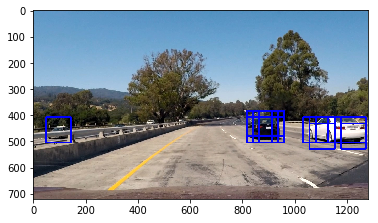

In [16]:
""" Main Prediction Process
"""
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_feat = True   # Spatial features on or off
hist_feat = True      # Histogram features on or off
hog_feat = True       # HOG features on or off


dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc      = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient   = dist_pickle["orient"]
pix_per_cell   = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size   = dist_pickle["spatial_size"]
hist_bins      = dist_pickle["hist_bins"]
print(dist_pickle)

# Check the prediction time for a single sample
t=time.time()
# Read the test image
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255.0

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[np.int(image.shape[0]/2), None], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("Hot Windows number")
print(len(hot_windows))

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


### Using HOG Sub-sampling Windows Search

In [5]:
""" Using HOG Sub-sampling Windows Search
    Sub Function """
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, \
              X_scaler, orient, pix_per_cell, cell_per_block, \
              spatial_size, hist_bins):
    """ Function: Find cars (HOG sub-sampling search and extract the features)
        Return  :"""
    
    draw_img = np.copy(img)
    # jpeg -> png
    img = img.astype(np.float32)/255.0
    # Init Windoe list
    window_list = []
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, \
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop  = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features    = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # print(yb)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                # Append window position to list
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #print(xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart)

    
    #print("test_features")
    #print(test_features[0].shape)
    return draw_img, window_list


{'cell_per_block': 2, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'hist_bins': 32, 'spatial_size': (32, 32), 'orient': 9, 'pix_per_cell': 8, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)}
window_list number
8


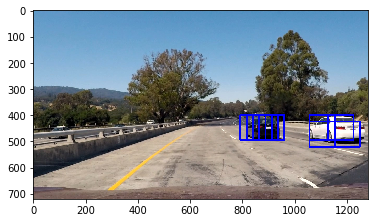

In [86]:
""" Test HOG Sub sampling  Windows Search
    Execute """
# parameter settings
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient   = dist_pickle["orient"]
pix_per_cell   = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size   = dist_pickle["spatial_size"]
hist_bins      = dist_pickle["hist_bins"]
print(dist_pickle)

# Read the image
image = mpimg.imread('test_images/test1.jpg')
ystart = 400
ystop  = 656
scale  = 1.5

# Main Process
out_img, window_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print("window_list number")
print(len(window_list))
plt.imshow(out_img)

window_list number in  test1.jpg
8
window_list number in  test2.jpg
0
window_list number in  test3.jpg
2
window_list number in  test4.jpg
11
window_list number in  test5.jpg
7
window_list number in  test6.jpg
15


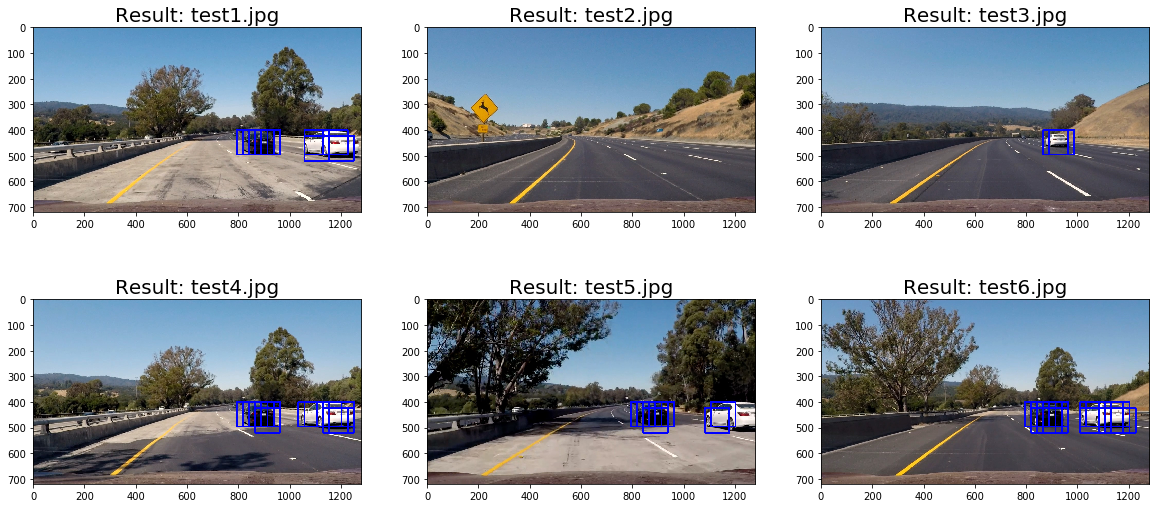

In [95]:
# Parameter settings
ystart = 400
ystop  = 656
scale  = 1.5

# Sub function
def getFileList(path):
    """ Function: Get "test images" file list
        arg     : file path
        return  : file pass list including file name """
    file_list = []
    for (root, dirs, files) in os.walk(path):
        for file in files:
            if 'test' in file:
                file_list.append( os.path.join(root,file).replace("\\", "/") )        
    return file_list

# Get the image lists
test_images_str = getFileList(r"./test_images")
image_list = []

# Plot setting
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.subplots_adjust(hspace = 0.001, wspace=0.2)
axs = axs.ravel()

# subplot
for i in np.arange(len(test_images_str)):
    #img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # Read the image
    image = mpimg.imread(test_images_str[i])
    # Main Process
    out_img, window_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    #axs[i].axis('off')
    title = "Result: " + test_images_str[i].split("/")[-1]
    axs[i].set_title(title, fontsize=20)
    axs[i].imshow(out_img)
    print("window_list number in ",test_images_str[i].split("/")[-1])
    print(len(window_list))

""" Save Plot
"""
plt.savefig(r"./output_images/Test_Sample_Result.jpg")

### Filtering False-Positive with Heat Map Technique

In [6]:
""" Sub Function
"""
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



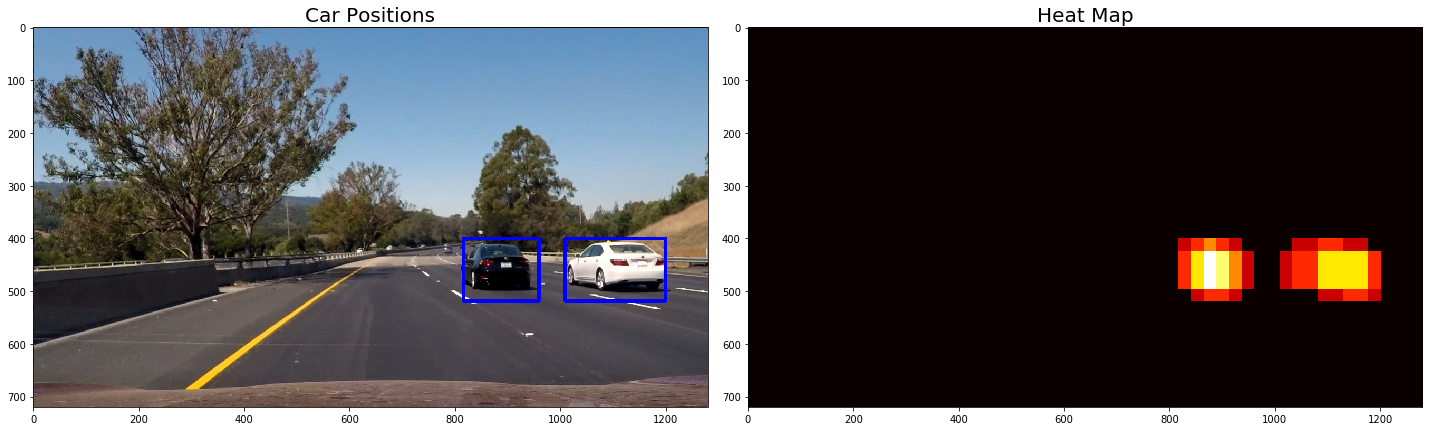

In [103]:
""" Main Process
"""
# In previous section, window_list is prepeared
box_list = window_list

# Read in image similar to one shown above
heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20, 10))
font_size = 20
plt.subplot(121)
plt.imshow(draw_img) # draw_img
plt.title('Car Positions', fontsize=font_size)

plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=font_size)
fig.tight_layout()

""" Save Plot
"""
plt.savefig(r"./output_images/HeatMap_Result.jpg")

## Vehicle Detection PipeLine

### A pipeline for video streams and Estimate a bounding box for vehicles detected.

In [11]:
from collections import deque

# parameters
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient   = dist_pickle["orient"]
pix_per_cell   = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size   = dist_pickle["spatial_size"]
hist_bins      = dist_pickle["hist_bins"]
print(dist_pickle)

ystart = 400
ystop  = 656
scale  = 1.5

# Heat map storage for time series filter
heatmaps = []
heatmaps = deque(maxlen=10)
        
def process_image(image):
    global heatmaps
    
    # Init
    out_img, window_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Create Data Buffer
    heat_img = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat_img = add_heat(heat_img, window_list)
    
    heatmaps.append(heat_img)
    heatmap_sum  = sum(heatmaps)
    
    # Apply threshold to help remove false positives
    heat_img = apply_threshold(heatmap_sum, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_img, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(image), labels)

    # return an image with lane line
    return result


{'cell_per_block': 2, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'pix_per_cell': 8, 'orient': 9, 'spatial_size': (32, 32), 'hist_bins': 32}


## Test for Pipeline on Videos

In this cell, Drawing lanes over video!
I evaluate my solution on 3 provided videos:

`test_video.mp4`

`project_video.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 1) test_video.mp4

In [14]:
test_project_output = 'output_images/test_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
test_project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_project_clip.write_videofile(test_project_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_out.mp4
[MoviePy] Writing video output_images/test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:12<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_out.mp4 

Wall time: 13.3 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_project_output))

## 2) Project_video.mp4

In [9]:
project_output = 'output_images/project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_out.mp4
[MoviePy] Writing video output_images/project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:11<00:00,  2.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_out.mp4 

Wall time: 7min 12s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))